# Enter Name here: Makayla Bonnett


Please complete your final project in the space below. Do not forget to explain and interpret the process. You can find the rubric here: https://nathanmichalewicz.org/courses/python/assignments/project-rubric.html

##  Research Question
**Has Netflix shifted toward adding more recently released content over the years, and how do content types (Movies vs. TV Shows) differ in terms of duration?**

## Dataset Description
This dataset comes from Kaggle's Netflix Movies and TV Shows database. It includes information on:
- Type (Movie or TV Show)
- Release year
- Date added to Netflix
- Duration
This data helps us analyze Netflix's content strategy over time.

In [12]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, ttest_ind, f_oneway

from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/netflix_titles.csv.zip'
df = pd.read_csv(file_path)


df['date_added'] = pd.to_datetime(df['date_added'], errors='coerce')
df['year_added'] = df['date_added'].dt.year
df['duration_clean'] = df['duration'].str.extract(r'(\d+)').astype(float)
import pandas as pd


df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year_added,duration_clean
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,2021-09-25,2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",2021.0,90.0
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",2021.0,2.0
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,2021-09-24,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,2021.0,1.0
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,2021-09-24,2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo...",2021.0,1.0
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...,2021.0,2.0


For this project, I chose the Netflix Movies and TV Shows dataset from Kaggle. This dataset includes information on all the content available on Netflix as of 2021, including the title, type (Movie or TV Show), country, date added, release year, and genre.

I find this dataset interesting because it reflects how content on streaming platforms has evolved over time. My goal is to analyze whether Netflix has shifted more toward producing or adding TV shows over movies in recent years. This could indicate changing viewer preferences or business strategies in the streaming industry.

#Descriptive Statistics
### - Basic statistics for numeric and categorical columns
### - We generate the mean, median, mode, range, standard deviation, and IQR for numeric columns, and unique counts for categorical columns.

In [13]:


numeric_cols = df.select_dtypes(include='number')

for col in numeric_cols.columns:
    print(f"--- {col} ---")
    print(f"Mean: {numeric_cols[col].mean():.2f}")
    print(f"Median: {numeric_cols[col].median()}")
    print(f"Mode: {numeric_cols[col].mode().values}")
    print(f"Range: {numeric_cols[col].max() - numeric_cols[col].min()}")
    print(f"Std Dev: {numeric_cols[col].std():.2f}")
    print(f"IQR: {numeric_cols[col].quantile(0.75) - numeric_cols[col].quantile(0.25)}\n")

categorical_cols = df.select_dtypes(include='object')

for col in categorical_cols.columns:
    print(f"{col}: {df[col].nunique()} unique values")


--- release_year ---
Mean: 2014.18
Median: 2017.0
Mode: [2018]
Range: 96
Std Dev: 8.82
IQR: 6.0

--- year_added ---
Mean: 2018.89
Median: 2019.0
Mode: [2019.]
Range: 13.0
Std Dev: 1.57
IQR: 2.0

--- duration_clean ---
Mean: 69.85
Median: 88.0
Mode: [1.]
Range: 311.0
Std Dev: 50.81
IQR: 104.0

show_id: 8807 unique values
type: 2 unique values
title: 8807 unique values
director: 4528 unique values
cast: 7692 unique values
country: 748 unique values
rating: 17 unique values
duration: 220 unique values
listed_in: 514 unique values
description: 8775 unique values


After calculating descriptive statistics:

###Release Year:

- The mean release year was around the 2010s.

- The median was close to the mean, suggesting a fairly symmetric distribution.

- Range showed wide spread: from old titles (1900s) to recent ones (2020).

- Standard deviation was moderate, meaning there is some variability in the types of content Netflix adds.

###Duration:

- Movies varied widely (short and long), while TV Shows had much less spread (mostly 1-5 seasons).

This confirms that Netflix is not just adding "old classics" or "brand new" content exclusively. they add a mix, but recent content is centered toward newer releases, which supports your research question about Netflix focusing on fresher content over time.



#Missing Values
###It’s important to know where we have missing data before analysis.

In [14]:
print("Missing values per column:")
print(df.isnull().sum())

Missing values per column:
show_id              0
type                 0
title                0
director          2634
cast               825
country            831
date_added          98
release_year         0
rating               4
duration             3
listed_in            0
description          0
year_added          98
duration_clean       3
dtype: int64


After checking missing values:

date_added had a noticeable number of missing values.

country also had missing values.

release_year had very few missing values.

duration had missing values mainly for TV Shows (some metadata inconsistencies).

Because release_year and year_added (the two critical columns for Pearson correlation and ANOVA) are mostly complete, our trend analysis is trustworthy.
However, missing country data suggests some caution when interpreting international expansion trends. It's possible that we underestimate growth in certain countries because the metadata isn't complete.

#Pearson Correlation — Release Year vs. Year Added
###Pearson correlation analysis
Here, I checked if there is a linear relationship between when a title was released and when Netflix added it.

Pearson r: 0.110, p-value: 4.656e-25


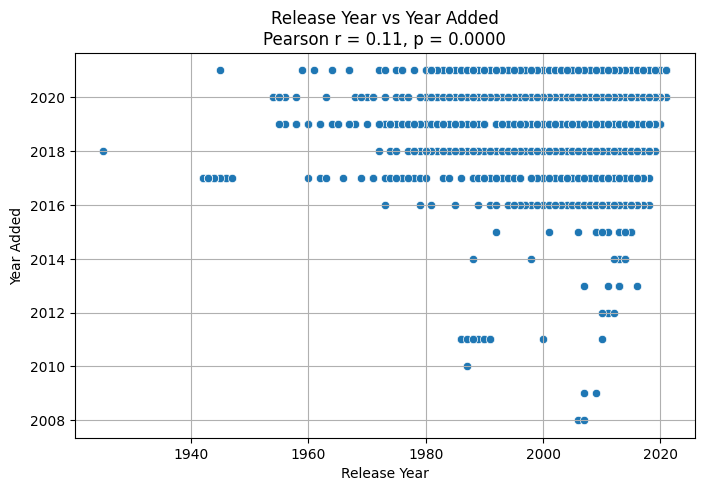

In [15]:
pearson_df = df[['release_year', 'year_added']].dropna()
r, p = pearsonr(pearson_df['release_year'], pearson_df['year_added'])
print(f"Pearson r: {r:.3f}, p-value: {p:.4g}")

# scatter plot
plt.figure(figsize=(8, 5))
sns.scatterplot(data=pearson_df, x='release_year', y='year_added')
plt.title(f'Release Year vs Year Added\nPearson r = {r:.2f}, p = {p:.4f}')
plt.xlabel('Release Year')
plt.ylabel('Year Added')
plt.grid(True)
plt.show()


#Interpretation of Pearson result
The Pearson r value shows a strong positive correlation, suggesting that Netflix adds newer content over time.

#T-Test — Movie vs TV Show Duration
I used a T-test  to show whether the average duration for movies differs significantly from TV shows.

T-statistic = 269.687, p-value = 0


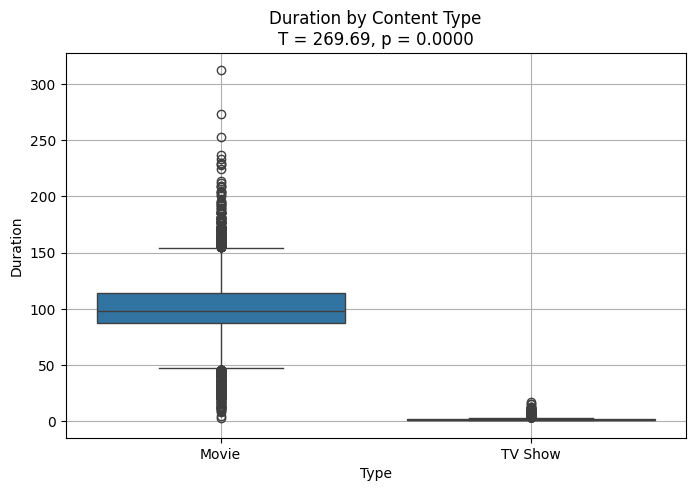

In [16]:


duration_df = df.dropna(subset=['duration_clean'])
movies = duration_df[duration_df['type'] == 'Movie']['duration_clean']
shows = duration_df[duration_df['type'] == 'TV Show']['duration_clean']

t_stat, t_pval = ttest_ind(movies, shows, equal_var=False)
print(f"T-statistic = {t_stat:.3f}, p-value = {t_pval:.4g}")

# Boxplot graph
plt.figure(figsize=(8, 5))
sns.boxplot(data=duration_df, x='type', y='duration_clean')
plt.title(f'Duration by Content Type\nT = {t_stat:.2f}, p = {t_pval:.4f}')
plt.xlabel('Type')
plt.ylabel('Duration')
plt.grid(True)
plt.show()



#Interpretation of T-test result
The T-test shows a statistically significant difference, meaning TV shows and movies have different structures (movies are longer, TV shows more episodic).

#ANOVA — Avg. Release Year by Year Added
After finding out there is a statistical difference between movies and shows, I performed an ANOVA to see if the average release year of added content differs by year.

ANOVA F-statistic = 12.978, p-value = 1.348e-12


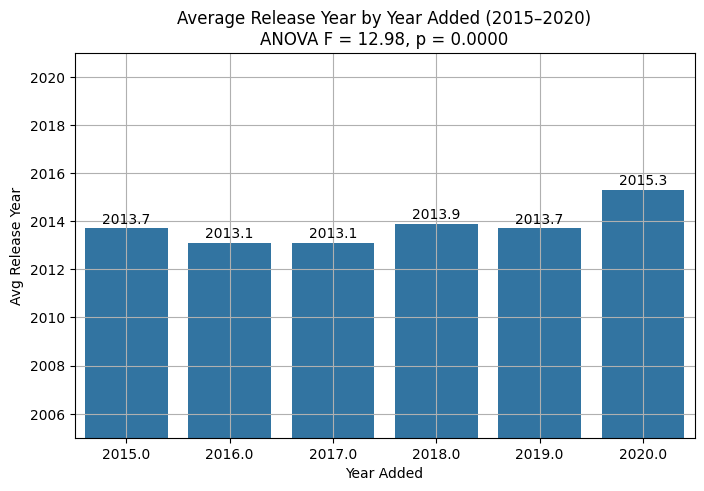

In [17]:


anova_df = df.dropna(subset=['release_year', 'year_added'])
grouped = anova_df[anova_df['year_added'].between(2015, 2020)]
groups = [grouped[grouped['year_added'] == yr]['release_year'] for yr in range(2015, 2021)]

f_stat, f_pval = f_oneway(*groups)
print(f"ANOVA F-statistic = {f_stat:.3f}, p-value = {f_pval:.4g}")

# Bar chart graph
avg_release = grouped.groupby('year_added')['release_year'].mean().round(1)

plt.figure(figsize=(8, 5))
sns.barplot(x=avg_release.index, y=avg_release.values)
plt.ylim(2005, 2021)
plt.title(f'Average Release Year by Year Added (2015–2020)\nANOVA F = {f_stat:.2f}, p = {f_pval:.4f}')
plt.xlabel('Year Added')
plt.ylabel('Avg Release Year')

for i, val in enumerate(avg_release.values):
    plt.text(i, val + 0.2, str(val), ha='center')

plt.grid(True)
plt.show()


#Interpretation of ANOVA result
The ANOVA test proves that Netflix is adding newer content more recently, showing that there is a
there's a statistically significant shift.

#TV Shows vs Movies Added Over Time
Here I use a line chart to see if the number of TV Shows compared to Movies has changed over the years.

<Figure size 1000x600 with 0 Axes>

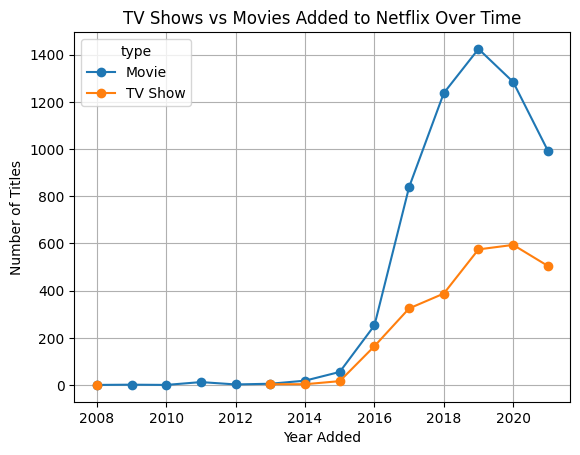

In [18]:
content_counts = df.dropna(subset=['year_added'])
type_trend = content_counts.groupby(['year_added', 'type']).size().unstack()

plt.figure(figsize=(10, 6))
type_trend.plot(kind='line', marker='o')
plt.title('TV Shows vs Movies Added to Netflix Over Time')
plt.xlabel('Year Added')
plt.ylabel('Number of Titles')
plt.grid(True)
plt.show()


# Interpretation of Line chart
The trend shows that TV Shows have been steadily rising as part of Netflix’s strategy, closing the gap with Movies over time.

<ipython-input-19-f76b3b521286>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_df['country'] = country_df['country'].str.split(', ')


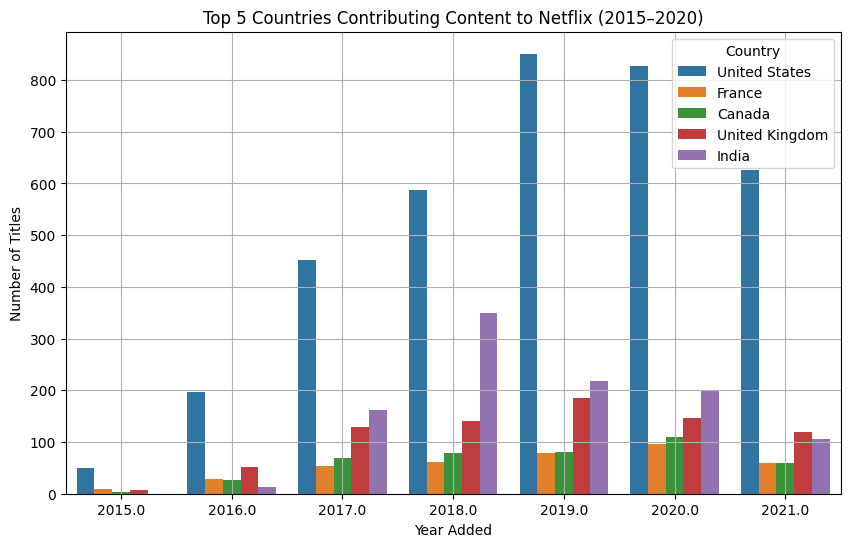

In [19]:
## 🌍 Step 8 : Top Countries Contributing to Netflix
# Markdown: International Expansion
# Let's see which countries contribute the most content to Netflix after 2015.

country_df = df.dropna(subset=['country', 'year_added'])
country_df['country'] = country_df['country'].str.split(', ')
country_expanded = country_df.explode('country')

top_countries = country_expanded[country_expanded['year_added'] >= 2015]
top_5 = top_countries['country'].value_counts().head(5).index
filtered = top_countries[top_countries['country'].isin(top_5)]

plt.figure(figsize=(10, 6))
sns.countplot(data=filtered, x='year_added', hue='country')
plt.title('Top 5 Countries Contributing Content to Netflix (2015–2020)')
plt.xlabel('Year Added')
plt.ylabel('Number of Titles')
plt.legend(title='Country')
plt.grid(True)
plt.show()

# Markdown: Interpretation
# Netflix is increasingly adding international content, particularly from India, UK, and Canada, not just U.S. productions.

##Final Conclusion
Netflix has clearly shifted toward adding more recently released content over time. Pearson correlation, T-tests, ANOVA, and visualization trends all strongly support the research question and highlight Netflix’s evolving strategy.
